In [1]:
import numpy as np
import os
import pandas as pd
import h5py
import seaborn as sns
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from toolbox.utils import set_random_seed
from toolbox.plt_utils import density_scatter

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [3]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# for TF To find gpu
os.environ["LD_LIBRARY_PATH"] = f"{os.environ['CONDA_PREFIX']}/lib:" + os.environ.get("LD_LIBRARY_PATH", "")

In [4]:
# set random seed for reproducibility
set_random_seed(seed=42)

2026-01-12 08:46:15.840274: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/valehvpa/miniconda3/envs/hist6/lib:/usr/local/cuda/lib64:/usr/local/cuda/lib64
2026-01-12 08:46:15.840303: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TensorFlow not installed, skipping tf seeding.


/home/valehvpa/miniconda3/envs/hist6/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


# Pileup coverage

I took note abotu this in my slide deck...

I took this from 1_5_2025.ipynb.

In [5]:
p = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_borzoi/histone/peak_scramble/maya_gapped_peaks/gm12878_h3k27ac_peaks.gappedPeak.canonical"
chip = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_borzoi/histone/peak_scramble/maya_coverage/5prime/chip/all_reps_5p_pooled.bw"
inputc = "/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_borzoi/histone/peak_scramble/maya_coverage/5prime/inputc/inputc_shifted_5p_pooled.bw"

df = pd.read_csv(
    p,
    sep="\t",
    header=None,
    index_col=False,
)
df["length"] = df[2] - df[1]
df.rename(columns={0: 'chrom', 1: 'start', 2: 'end'}, inplace=True)

import pyBigWig
chip_bw = pyBigWig.open(chip)
inputc_bw = pyBigWig.open(inputc)
def get_cts(
    peaks_df,
    bw,
    width,
    get_total_cts: bool = False,
):
    vals = []

    for _, r in peaks_df.iterrows():
        # w = r['length'] if width is None else width
        if not get_total_cts:
            vals.append(
                np.nan_to_num(bw.values(r['chrom'],
                                        r['start'],
                                        r['end']))
            )
        else:
            vals.append(np.array([
                np.nansum(bw.values(r['chrom'],
                                    r['start'],
                                    r['end']))
            ]))

    return vals

chip_cts = get_cts(df, chip_bw, None, get_total_cts=True)
inputc_cts = get_cts(df, inputc_bw, None, get_total_cts=True)

# lfc = []
# for o, p in zip(chip_cts, inputc_cts):
#     lfc.append(np.log2((o[0] + 1) / (p[0] + 1)))
# lfc = np.array(lfc)

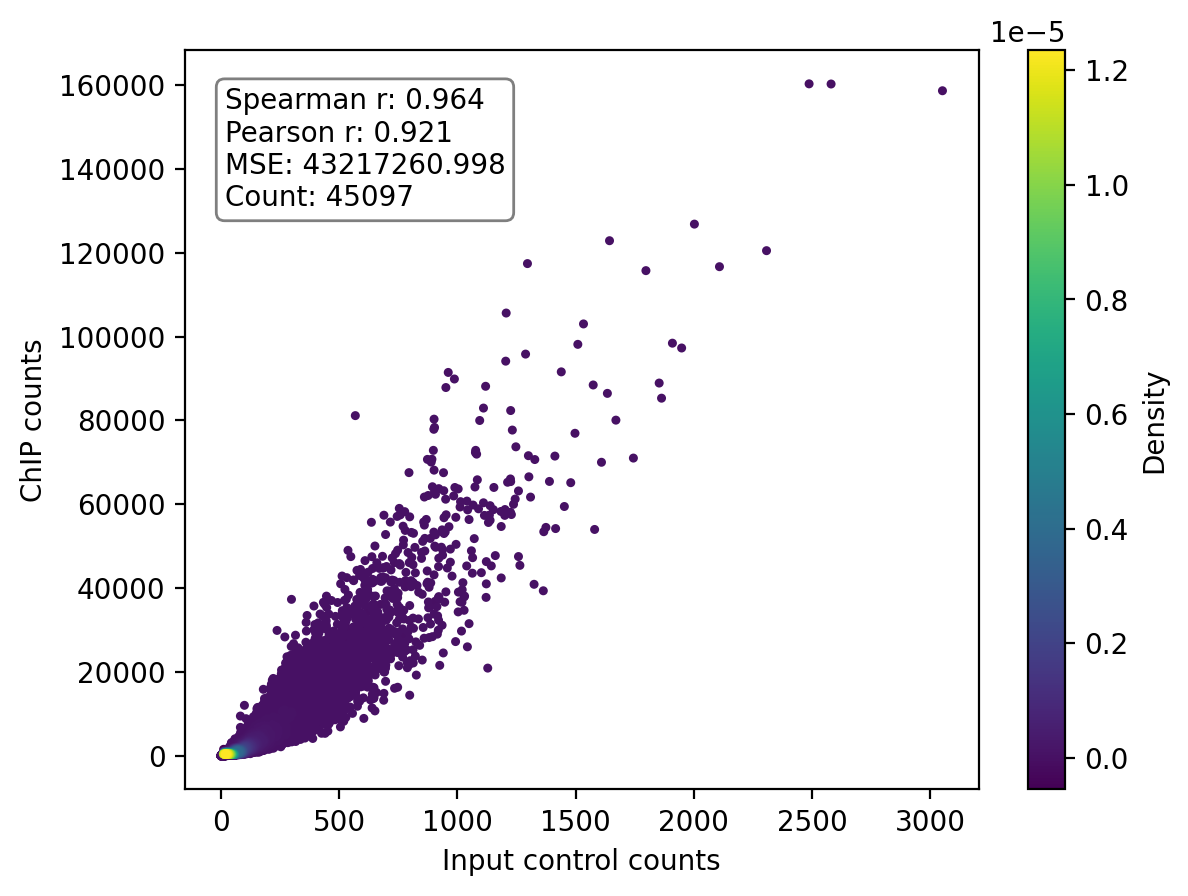

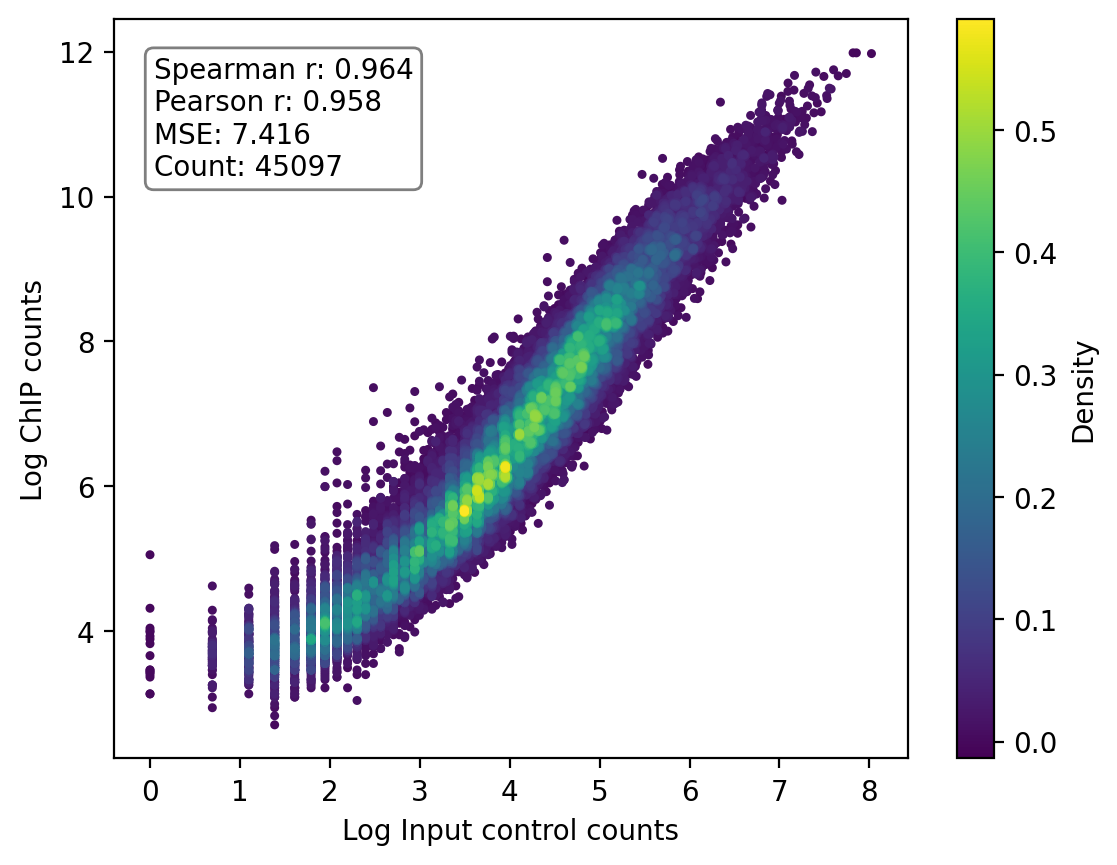

In [7]:
chip_cts = np.array([v[0] for v in chip_cts]).squeeze()
inputc_cts = np.array([v[0] for v in inputc_cts]).squeeze()

# plot chip_cts vs inputc_cts
density_scatter(inputc_cts, chip_cts, "Input control counts", "ChIP counts", s=5, bins=200, incl_stats=True) 
plt.show()

# plot log chip_cts vs log inputc_cts
density_scatter(np.log1p(inputc_cts), np.log1p(chip_cts), "Log Input control counts", "Log ChIP counts", s=5, bins=200, incl_stats=True) 
plt.show()

In [8]:
# fit a regression line to chip_cts vs inputc_cts
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(inputc_cts, chip_cts)
print(f"slope: {slope}, intercept: {intercept}")

# fit a regression line to log chip_cts vs log inputc_cts
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(np.log1p(inputc_cts), np.log1p(chip_cts))
print(f"slope: {slope}, intercept: {intercept}")
# print residuals (mse)
residuals = np.log1p(chip_cts) - (slope * np.log1p(inputc_cts) + intercept)
mse = np.mean(residuals ** 2)
print(f"mse: {mse}")

slope: 44.859441434003564, intercept: -1720.2909551631114
slope: 1.3801134828593733, intercept: 1.1133347396813527
mse: 0.19810091504255825


In [9]:
bp = f"/large_storage/goodarzilab/valehvpa/data/projects/scCisTrans/for_hist/histobpnet_v2/train/instance-20260112_084254"
p = f"{bp}/pt_artifacts/best_model.ckpt"
from histobpnet.model.histobpnet_wrapper_v2 import HistoBPNetWrapperV2
model_wrapper = HistoBPNetWrapperV2.load_from_checkpoint(p, map_location='cpu')

In [10]:
model_wrapper.model.bpnet.linear_w_ctrl.weight, model_wrapper.model.bpnet.linear_w_ctrl.bias

(Parameter containing:
 tensor([[0.1659, 1.5055]], requires_grad=True),
 Parameter containing:
 tensor([-0.0240], requires_grad=True))

The params (1.3888 and -0.1147) pretty closely match teh slope and intercept of the regression line fitted to log input control vs log chip counts.

Even the mean residual (mse) matches pretty close the mse on test_scatter_peaks for this model: https://wandb.ai/valehamiri/histobpnet/runs/nhd69x74?nw=nwuservalehamiri. Both are ~0.2 (though Im not sure why that s not the case for the mse on the train_scatter_peaks and val_scatter_peaks...).